In [1]:
from typing import Union, List, Any, Optional, Dict

import os
import re
import time
import json
import glob
import pickle
import random
import urllib
import requests
import subprocess
import concurrent.futures

import numpy as np
import pandas as pd

from tqdm import tqdm
from pathlib import Path


from utils import cleaning_utils
from utils import cluster_utils
from utils import IDF_computation
from utils import embedding_utils as embedding
from utils.customdocument import CustomDocument

### 1 Clustering the terms

<div class="alert alert-block alert-info">
We'll also try an unsupervised clustering-based approach. The aim is to assign a domain to UNSEEN spans. <br>
    
Using unsupervised clustering means we have to pick a value for K ~ the number of clusters. K determines roughly how many terms are filtered (each cluster that has a background term in it), a low K will have many terms removed and a high K will have few terms removed.
</div>

* As a heuristic for determining a reasonable value for K we rely on the Elbow method and sillhouette score; these are not optimal solutions but this doesn't matter much in our case. 
  * In general, our dataset is larger and more diverse than usually desired with KMeans. As an example, a rule of thumb for selecting K is the square root of half the number of samples `k = (16000/2)**.5 = 89.4`. This is a completely unrealistic value of K for our usecase, as it would mean there are only 90-odd concepts that occur in our sets of input corpora.
  * However, we will see that (1) the elbow method, (2) sillhouette scores, as well as (3) gap statistics indicate how hard it is to cluster a large set of text embeddings. 
  
Based on these heuristics we'll pick a K that could reasonable well distinguish whether an unseen term is within the AEC domain.
  

In [2]:
embedding_output_fp = Path("output/")
unique_background_spans = pickle.load(open(embedding_output_fp.joinpath("unique_background_spans.pkl"), 'rb'))
unique_spans = pickle.load(open(embedding_output_fp.joinpath("unique_spans.pkl"), 'rb'))
standardised_clustering_data = pickle.load(open(embedding_output_fp.joinpath("standardised_embeddings.pkl"), 'rb'))

In [3]:
# clustering approach (I think I'll simply use the kNN approach)
def compute_clusters_sklearn(standardised_clustering_data, cluster_model_fp: Path, num_clusters=10):
    """
    Note that this clustering function relies on the CPU. It won't be able to compute clusters for large 
    amounts of inputs, e.g., 100.000 spans. When using a large number of clusters (e.g. 20K) it is also
    a lot slower than a GPU implementation for. Or it may simply not converge! 
    For large inputs/num_clusters you'll need to use compute_clusters_kmcuda, and have access to a GPU.
    """
    print(f"Computing {num_clusters} clusters from scratch, using sklearn on the CPU")
    start_time = time.time()
    sklearn_kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=5, n_init=1, random_state=14,
                            tol=0.0001, verbose=0)
    assignments = sklearn_kmeans.fit_predict(standardised_clustering_data)
    centroids = sklearn_kmeans.cluster_centers_
    print("Clustering took {}".format(time.time() - start_time))
    with open(cluster_model_fp, 'wb') as f:
        pickle.dump((centroids, assignments), f)

In [4]:
clustering_type = "sklearn"   # deprecated; we're only using the sklearn implementation of kmeans 
# Computing clusters on the CPU
for num_clusters in range(500,12001, 500):
    cluster_file = embedding_output_fp.joinpath(f"sklearn_{num_clusters}_clusters.pkl")
    if not os.path.exists(cluster_file):
        compute_clusters_sklearn(standardised_clustering_data, cluster_file, num_clusters)
    else:
        print(f"sklearn cluster file exists for {num_clusters} clusters")

sklearn cluster file exists for 500 clusters
sklearn cluster file exists for 1000 clusters
sklearn cluster file exists for 1500 clusters
sklearn cluster file exists for 2000 clusters
sklearn cluster file exists for 2500 clusters
sklearn cluster file exists for 3000 clusters
sklearn cluster file exists for 3500 clusters
sklearn cluster file exists for 4000 clusters
sklearn cluster file exists for 4500 clusters
sklearn cluster file exists for 5000 clusters
sklearn cluster file exists for 5500 clusters
sklearn cluster file exists for 6000 clusters
sklearn cluster file exists for 6500 clusters
sklearn cluster file exists for 7000 clusters
sklearn cluster file exists for 7500 clusters
sklearn cluster file exists for 8000 clusters
sklearn cluster file exists for 8500 clusters
sklearn cluster file exists for 9000 clusters
sklearn cluster file exists for 9500 clusters
sklearn cluster file exists for 10000 clusters
sklearn cluster file exists for 10500 clusters
sklearn cluster file exists for 1

In [5]:
clustering_files = embedding_output_fp.glob(f'{clustering_type}_*.pkl')

Computing elbow and silhouette (if not too many num_clusters) scores.


24it [00:00, 1441.09it/s]

Loading values from existing csv file: output/sklearn_4500_clusters.pkl
Loading values from existing csv file: output/sklearn_5000_clusters.pkl
Loading values from existing csv file: output/sklearn_3500_clusters.pkl
Loading values from existing csv file: output/sklearn_2000_clusters.pkl
Loading values from existing csv file: output/sklearn_12000_clusters.pkl
Loading values from existing csv file: output/sklearn_500_clusters.pkl
Loading values from existing csv file: output/sklearn_2500_clusters.pkl
Loading values from existing csv file: output/sklearn_3000_clusters.pkl
Loading values from existing csv file: output/sklearn_5500_clusters.pkl
Loading values from existing csv file: output/sklearn_4000_clusters.pkl
Loading values from existing csv file: output/sklearn_1000_clusters.pkl
Loading values from existing csv file: output/sklearn_11500_clusters.pkl
Loading values from existing csv file: output/sklearn_10000_clusters.pkl
Loading values from existing csv file: output/sklearn_7500_clu

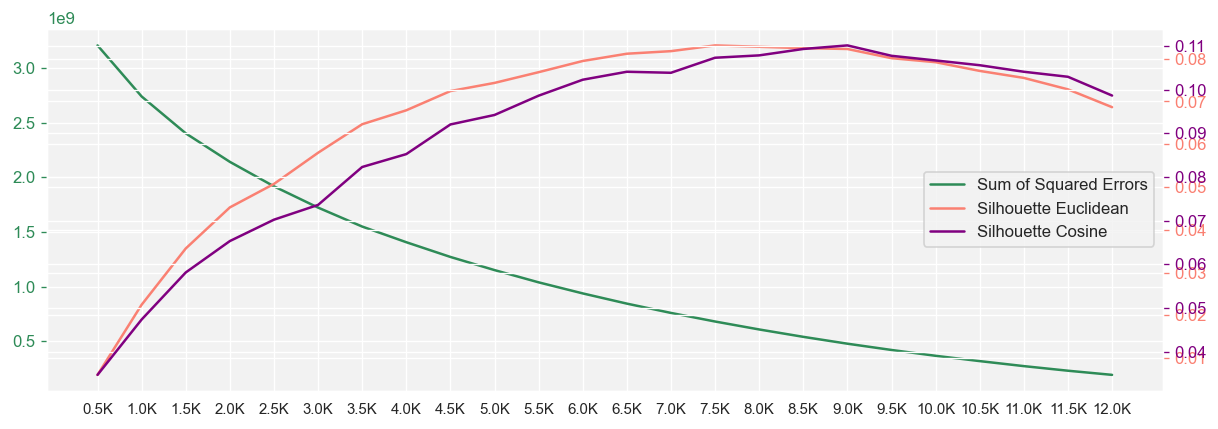

In [6]:
# This takes a bit of time; 6-10 minutes per cluster size for 2000-6000 clusters 
# but resulting scores are saved in a csv and reused
es = cluster_utils.ElbowAndSilhouette(embedding_output_fp)
es.compute_scores_for_models(clustering_type, clustering_files)

* Sum of Squared Errors (SSE) is an indication of the sum of squared distances between points in a cluster and the cluster centroid.
* The silhouette score of a point measures how close that point lies to its nearest neighbor points, across all clusters. 

While SSE and the silhouette score are often used for determining a good value for K, they do not always provide the right type of insight in the optimal K. Better alternatives exist (Schubert, 2022) and one of these options is the gap statistic (Tibshirani et al., 2001).

In [7]:
## Gap statistic; 
## Uncomment to run, takes a while and basically ends up saying that K should be close to the number of input data points
# optimalK = OptimalK(n_jobs=6, parallel_backend='joblib')
# n_clusters = optimalK(standardised_clustering_data, cluster_array=np.arange(250, 16251, 500))
# optimalK.gap_df.head()

In [8]:
# print(f"Optimal number of clusters: {n_clusters}")
# plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
# plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
#             optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
# plt.grid(True)
# plt.xlabel('Cluster Count')
# plt.ylabel('Gap Value')
# plt.title('Gap Values by Cluster Count')
# plt.show()

* Based on the Elbow score, we might expect K to lie around 3000. 
* Based on the sillhouette scores the ideal K may be closer to 7500.
* Based on the Gap Statistics K should be somewhere closer to 15000.

We are using the cluster-assignment to distinguish between AEC and non-AEC terms. Based on the number of non-domain terms in a cluster, we will assign a likelihood of the cluster being within the AEC domain. A large number of clusters will make it hard to classify unseen terms into a group of similar spans. A very small number of clusters will make it hard to distinguish whether a cluster contains mostly AEC or non-AEC terms.

### 2 Filtering terms based on cluster assignment

<div class="alert alert-block alert-info">
We first create a lookup-dictionary for the embedding and assigned cluster of each span
</div>

In [9]:
# Based on the above we will set the number of clusters to 4500
chosen_num_clusters = 4500
cluster_model_to_use = embedding_output_fp.joinpath(f'{clustering_type}_{chosen_num_clusters}_clusters.pkl')

In [10]:
centroids, assignments = pickle.load(open(cluster_model_to_use, 'rb'))
cluster_dict_creator = cluster_utils.ClusterDict(unique_background_spans, 
                                                 unique_spans, 
                                                 standardised_clustering_data,  # important to use standardised embeddings
                                                 centroids, 
                                                 assignments,
                                                 embedding_fp=embedding_output_fp)

In [11]:
phrase_cluster_dict, clusters_with_background_terms = cluster_dict_creator.prep_cluster_dict(chosen_num_clusters)

Computing the cluster dictionary.


In [32]:
# reload kNN based features
span_features_df = pd.read_csv(embedding_output_fp.joinpath("span_features.csv"), index_col=1)
columns = ['span', 'num_background_neighbours', 'num_foreground_neighbours', 'foreground_cnt', 'background_cnt', 'TFIDF_fore_back']
span_features_df.set_axis(columns, axis='columns', inplace=True)
span_features_df[:3]

,span,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
span_idx,,,,,,
0,vessel,236,264,3,0,0.829818
1,expansion water,47,453,2,0,0.942027
2,a hot water system,48,452,2,0,0.797904


In [42]:
row = span_features_df.loc[span_features_df['span'] == 'vessel']
row['TFIDF_fore_back'].values[0]

0.8298175215895447

In [129]:
def span_filter(all_spans_in_cluster, background_spans_in_cluster, span_features_df):
    """
    We want to (1) identify clusters that we might want to remove and (2) spans that we might want to keep within
    those clusters. Could play around with different settings or add features here.
    """
    
    # span-level features
    min_TFIDF = .4
    minimum_foreground_neighbours = 200
    
    spans_making_the_cut = []
    for span in all_spans_in_cluster:
        row = span_features_df.loc[span_features_df['span'] == 'vessel']
        
#         nbckgrn = row['num_background_neighbours'].values[0]
        nfrgrn = row['num_foreground_neighbours'].values[0]
#         fc = row['foreground_cnt'].values[0]
#         bc = row['background_cnt'].values[0]
        TFIDF = row['TFIDF_fore_back'].values[0]
        
        if TFIDF > min_TFIDF and (nfrgrn > minimum_foreground_neighbours):
            spans_making_the_cut.append(span)
    
     
    # cluster-level feature
    ratio_fore_ground_background = len(background_spans_in_cluster) / len(all_spans_in_cluster)
    ratio_making_the_cut = 1 - (len(number_of_spans_making_the_cut) / len(all_spans_in_cluster))
    
    
    # cluster-level decision
    cluster_ratio_w = 1
    domain_spans_w = 1
    if (ratio_fore_ground_background * cluster_ratio_w) + (ratio_making_the_cut * domain_spans_w) > 1:
        # cluster will be removed!
        return (True, spans_making_the_cut)
    else:
        
        return (False, spans_making_the_cut)
    
        

In [133]:
# Preparing the filter based on cluster assignment
domain_terms = []
filtered_terms = []
clusters_to_filter = []
potential_domain_terms = []

max_terms_to_show = 5
for cluster_id in phrase_cluster_dict.keys():
    all_spans_in_cluster = [span for score, span in phrase_cluster_dict[cluster_id]]
    if cluster_id in clusters_with_background_terms:
        background_spans_in_cluster = clusters_with_background_terms[cluster_id]
    else:
        background_spans_in_cluster = []
    print()
    x = cluster_feature_filter(all_spans_in_cluster, 
                                                                  background_spans_in_cluster, 
                                                                  span_features_df)
    print(x)
    if cluster_made_it:
        filtered_terms += [x for x in all_spans_in_cluster if x not in spans_that_made_it]
        potential_domain_terms += spans_that_made_it
        clusters_to_filter.append(cluster_id)
#         print(f"Filtered terms: {all_spans_in_cluster[:max_terms_to_show]}")
    else:
#         print(f"AEC domain: {all_spans_in_cluster[:max_terms_to_show]}")
        domain_terms += all_spans_in_cluster


False


NameError: name 'cluster_made_it' is not defined

In [123]:
print("AEC domain terms: ", len(domain_terms))
random.sample(domain_terms, 15)

AEC domain terms:  16441


['roof venting',
 'arrangements access',
 'Building Regulation Fire safety',
 'Reagents',
 'All data',
 'a legal requirement',
 'the correlation table',
 'performance safety characteristics',
 'the integrity',
 'protective barriers',
 'Thermoplastic materials',
 'closers',
 'the guidance 5 14',
 'a globally',
 'a mass per']

In [124]:
print("Filtered clusters: ", len(clusters_to_filter))
print("Filtered terms: ", len(filtered_terms))
random.sample(filtered_terms, 15)

Filtered clusters:  0
Filtered terms:  0


ValueError: Sample larger than population or is negative

In [ ]:
removed_terms = [span for span in unique_spans if span in filtered_terms and span not in unique_background_spans]

In [ ]:
print("Terms extracted from the Approved documents, removed through filtering: ", len(removed_terms))
removed_terms

In [20]:
print("{} terms were filtered ({:.2f}%)".format(len(filtered_terms), len(filtered_terms)/len(filtered_terms+domain_terms)*100))
print("Terms that were filtered:")
random.sample(filtered_terms,10)

3664 terms were filtered (35.74%)
Terms that were filtered:


['utility space',
 'the thermal performance',
 '] resistance of elements of',
 'a spread',
 'Open appliance',
 'a performance',
 'sub - paragraph ii',
 'regeneration',
 'a band material',
 'length of']

In [21]:
print("{} terms were kept ({:.2f}%)".format(len(domain_terms), len(domain_terms)/len(filtered_terms+domain_terms)*100))
print("Terms that were kept:")
random.sample(domain_terms,10)

6588 terms were kept (64.26%)
Terms that were kept:


['Lifts',
 'a fixed building service',
 'Table 12',
 'The enclosure',
 'the firefighting stair',
 'www wras co uk',
 'THE PROVISION',
 'the total useful',
 'Lifts Regulations 1997',
 'Interpretation']

In [22]:
cluster_sizes = [len(v) for v in phrase_cluster_dict.values()]
print(f'Average number of terms per cluster: {sum(cluster_sizes)/len(cluster_sizes)}')


Average number of terms per cluster: 3.6535555555555557


In [23]:
# Check the largest cluster(s)
largest_cluster_size = np.max([len(v) for v in phrase_cluster_dict.values()])
print(largest_cluster_size)
[v for v in phrase_cluster_dict.values() if len(v) == largest_cluster_size]

99


[[[139.01773071289062, 'necessary'],
  [152.12646484375, 'provisions'],
  [162.94393920898438, 'particular'],
  [163.99697875976562, 'competent'],
  [165.74684143066406, 'these'],
  [170.29425048828125, 'certificate'],
  [170.53988647460938, 'external'],
  [172.15859985351562, 'approved'],
  [172.29647827148438, 'type'],
  [172.86874389648438, 'specified'],
  [173.8490753173828, 'provided'],
  [174.46298217773438, 'carried'],
  [176.34771728515625, 'need'],
  [176.40216064453125, 'risks'],
  [178.16590881347656, 'dwelling'],
  [178.54881286621094, 'cavity'],
  [182.03683471679688, 'internal'],
  [183.06903076171875, 'protected'],
  [183.52154541015625, 'resistance'],
  [183.56385803222656, 'applicable'],
  [185.00723266601562, 'there'],
  [186.37130737304688, 'compartment'],
  [189.62973022460938, 'areas'],
  [194.02357482910156, 'elements'],
  [195.21621704101562, 'comply'],
  [195.38121032714844, 'details'],
  [196.44729614257812, 'apply'],
  [198.8440704345703, 'escape'],
  [201.616

In [24]:
# check the smallest clusters, select 10 examples
print(len([v for v in phrase_cluster_dict.values() if len(v) == 1]))
random.sample([v for v in phrase_cluster_dict.values() if len(v) == 1], 10)

2244


[[[0.0, 'UT UP TO']],
 [[0.0, 'downslope']],
 [[0.0, 'Diagram D5 Number Plant Roof']],
 [[0.0, 'Sa classification']],
 [[0.0, 'Number of occupants']],
 [[0.0, 'prolongation']],
 [[0.0, 'Vert']],
 [[0.0, 'cover moulds']],
 [[0.0, 'a multicentre']],
 [[0.0, 'supporting structure']]]